In [1]:
%autosave 0
from __future__ import absolute_import, division, print_function
%pylab inline


import cv2
import scipy.misc
import skimage.util

import numpy as np
import glob
import os.path
import xml.etree.ElementTree as ET
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
import random
from scipy import ndimage
from skimage import io
from skimage import transform
import math

from PIL import Image, ImageEnhance
from scipy import signal
from sklearn import preprocessing
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


Autosave disabled
Populating the interactive namespace from numpy and matplotlib


In [2]:
vocabulary = {}
vocabulary_path = "some.mat"
def getIndex(c,voc):
    for name, age in voc.iteritems():
        if age == c:
            return name
    print("-"*30,"error-",c)
    return None

if os.path.exists(vocabulary_path):
    imgs=scipy.io.loadmat(vocabulary_path)['vocabulary']
else:
    nrC=1
    vocabulary['%%'] = 0 
    '''
    c = '0'
    
    while ord(c) != ord('9')+1:
        vocabulary[c] = nrC
        nrC = nrC + 1
        c = chr(ord(c)+1)
    c = 'A'
    while ord(c) != ord('Z')+1:
        vocabulary[c] = nrC
        nrC = nrC + 1
        c = chr(ord(c)+1)
    '''
    c = 'a'
    while ord(c) != ord('z')+1:
        vocabulary[c] = nrC
        nrC = nrC + 1
        c = chr(ord(c)+1)
    '''
    cr = [',','.','"','\'',' ','-','#','(',')',';','?',':','*','&','!','/','']
    for c in cr:
        vocabulary[c] = nrC
        nrC = nrC + 1
    '''
    vocabulary[' '] = nrC
    nrC += 1
    vocabulary[''] = nrC
    
def preprocessTarget(line):
    
    QUOT_TOKEN_Init = "&quot;"
    QUOT_TOKEN = '"'
           
    FIRST_INDEX = ord('a') - 4  # 0 is reserved to space

    targets = line.strip().replace(QUOT_TOKEN_Init, QUOT_TOKEN)
        
    targets = np.asarray([vocabulary[x]  for x in targets])
    
    return targets



vocabulary 

{'': 28,
 ' ': 27,
 '%%': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [3]:
maxL = 100#inaltimea
maxi=0
def processPage(nameXml,nameImg,words=False,maxW=400):
    tree = ET.parse(nameXml)
    root = tree.getroot()
    global maxi
    letters = list()
    coords = list()
    form = cv2.imread(nameImg, cv2.IMREAD_GRAYSCALE )
    print(form.shape)
    imgs = []
    texts = []
    lengths = []
    for i,line in enumerate(root[1]):
        #plt.subplot(10,1,i+1)
        if int(line.attrib['dsy'])-int(line.attrib['asy'])>maxL:
            continue
        if words: 
            b = 0
            e = 0
            t = ""
            ss=0
            jj=0
            for w in line:                
                if(w.tag == "lower-contour" or w.tag == "upper-contour" or len(w) == 0):
                        continue
                #print (w.attrib)
                
                b1 = 0
                e1 = 0
                sss=0
                jjj=0
                for letter in w:
                    if b1==0:
                        b1 = int(letter.attrib['x'])
                        jjj = int(letter.attrib['y'])
                    e1 = max(e1,int(letter.attrib['x'])+int(letter.attrib['width']))
                    b1 = min(b1,int(letter.attrib['x']))
                    jjj = min(jjj,int(letter.attrib['y']))
                    sss = max(sss,int(letter.attrib['y'])+int(letter.attrib['height']))
                
                #b1 = int(w[0].attrib['x'])
                #e1 = int(w[len(w)-1].attrib['x']) + int(w[len(w)-1].attrib['width'])
                if b==0:
                    b=b1
                    e=e1
                    ss=sss
                    jj=jjj
                if e1-b>maxW and t!="":                        
                        img = form[jj:ss,b:e]
                        img = cv2.resize(img, (0,0), fx=0.3, fy=0.3)
                        ret,thresh1 = cv2.threshold(img,int(line.attrib['threshold']),255,cv2.THRESH_BINARY)
                        thresh1 =1.-(thresh1/255)
                        ok=1
                        for llt in t:
                            if llt not in vocabulary:
                                ok = 0
                                break
                        if ok==1  and len(t)*4<thresh1.shape[1] and ss-jj<maxL:
                            maxi=max(maxi,img.shape[0])
                            texts.append(preprocessTarget(t))
                            imgs.append(img)
                            lengths.append(thresh1.shape[1])
                            #print(t)
                            if t.strip()=="it is" and False :
                                print (nameXml)
                                plt.imshow(thresh1)
                                return None
                        if e1-b1 > maxW:
                            b=0
                            t=""
                            continue
                        b = b1
                        e = e1
                        jj = min(jj,jjj)
                        ss= max(ss,sss)
                        t=w.attrib['text']
                else:
                        if e1-b1 > maxW:
                            b=0
                            continue
                        t = t + " " + w.attrib['text']
                        e = e1
                        jj = min(jj,jjj)
                        ss= max(ss,sss)
                    #print (letter.attrib)
            if e-b < maxW and t!="":
                    #correct latimea
                    img = form[jj:ss,b:e]#int(line.attrib['asy']):int(line.attrib['dsy'])
                    img = cv2.resize(img, (0,0), fx=0.3, fy=0.3)
                    ret,thresh1 = cv2.threshold(img,int(line.attrib['threshold']),255,cv2.THRESH_BINARY)                    
                    maxi=max(maxi,img.shape[0])
                    ok = 1
                    for llt in t:
                            if llt not in vocabulary:
                                ok = 0
                                break
                    if ok==1 and len(t)*4<thresh1.shape[1] and ss-jj<maxL:
                        texts.append(preprocessTarget(t))
                        thresh1 =1.-(thresh1/255)
                        imgs.append(img)
                        lengths.append(thresh1.shape[1])
                        #print(t)
                        if t.strip()=="not in" and False:
                                plt.imshow(thresh1)
                                #print(t)
                                print(line.attrib)
                                print (nameXml)
                                return None
            #break    
        else:
            print(11)
            img = form[int(line.attrib['asy']):int(line.attrib['dsy'])]
            ret,thresh1 = cv2.threshold(img,int(line.attrib['threshold']),255,cv2.THRESH_BINARY)
            
            maxi=max(maxi,img.shape[0])
            texts.append(preprocessTarget(line.attrib['text']))
            imgs.append(thresh1)
            lengths.append(thresh1.shape[1])
        
    return [texts,imgs,lengths]

    
nameXml = '../xml/b05-074.xml'
nameImg = '../forms/b05-074.png'#'forms/a01-030u.png'#'forms/a01-113.png'

t=processPage(nameXml,nameImg,True)
#t[0]
#print (maxi)
print (len(t[0]))
#for e,i in enumerate(t[0]):
#    print(decodePrediction([[],t[0][e]]))
#plt.imshow(t[1][0])
l = 0;h = 0
plt.figure(figsize=(15,25))
for e in range(len(t[0][-9*2:])):
    break
    l = max(l,len(t[1][e][:,0]))
    h = max(h,len(t[1][e][0]))
    plt.subplot(9,2,e+1)
    plt.imshow(t[1][e])
l,h

(3542, 2479)
17


(0, 0)

In [4]:

def get_features(img, thesh=100):
    l = [img]
    for i in range(3):
        l.append(cv2.Sobel(img,cv2.CV_64F,1,0,ksize=(i*2+1)))
        l.append(cv2.Sobel(img,cv2.CV_64F,0,1,ksize=(i*2+1)))
    for i in range(1):
        l.append(cv2.Canny(img,100+10*i,200))
    for i in range(3):#block size, ksize, k harris
        for j in range(3):
                l.append(cv2.cornerHarris(img,2+j,(i*2+1),5))
    theta, bwimg = cv2.threshold(img, 100, 255, cv2.THRESH_OTSU)
    l.append(bwimg)
    #l.append(correctSlant(img,tt=False))
    l = [(i-np.amin(i))/(np.amax(i)-np.amin(i)) for i in l]
    return l
    #p = [np.expand_dims(preprocessing.scale(np.float32(i)),2) for i in l]
    #return np.concatenate(p,2)
imgs = get_features(t[1][0])
#print(imgs.shape)
plt.figure(figsize=(15,25))
for i  in range(len(imgs)):
    break
    plt.subplot(20,2,i+1),plt.imshow(imgs[i],cmap = 'gray')
    plt.title('{}'.format(i)), plt.xticks([]), plt.yticks([]), colorbar()

(24, 36, 24, 18) (28, 112)
[17, 21, 19, 11, 9, 24, 22, 20, 24, 24, 24, 24, 24, 24, 19, 1, 17]


<matplotlib.colorbar.Colorbar instance at 0x7fb0c4af2170>

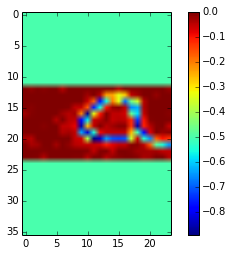

In [5]:
def getSlices(img,w,stride=3,W=130,H=36):
    img = 1.0 - img
    assert w%2==0
    w1 = img.shape[1]
    ll = 100
    l = []
    #imgr = resize(img,height=H)
    #if imgr.shape[1]<=W:
    #    img = imgr
    if W!=None and H!=None:
        if img.shape[0]!=H and int((H-img.shape[0])/2)>0:
            img = np.insert(img, [0]*int((H-img.shape[0])/2), 0.5, axis=0)
        if img.shape[0]!=H:
            img = np.insert(img, [img.shape[0]]*(H-img.shape[0]), 0.5, axis=0)
        if img.shape[1]!=W:
            img = np.insert(img, [img.shape[1]]*(W-img.shape[1]), 0.5, axis=1)    
    if img.shape[1]%w!=0 and False:
        img = np.insert(img, [img.shape[1]]*(w-(img.shape[1]%w)), 0.5, axis=1)
    i = 0
    #return img, w1
    #add begining and ending offset
    #img = np.insert(img, [img.shape[1]]*(int(w*0.6)), 0, axis=1)  
    #img = np.insert(img, [0]*(int(w*0.6)), 0, axis=1)  
    
    #make slices
    
    cosineWindow = [signal.cosine(w) for i in range(H)]
    while i<img.shape[1]-w:
        if i>w1 and ll == 100:
            ll = len(l)
        #apply cosine transform
        frame = img[:,i:i+w]
        #frame = frame*np.array(cosineWindow)      
        l.append(frame)
        i=i+3
    if len(np.asarray(l)) < ll+1:
        ll = len(np.asarray(l))-1
    return np.asarray(l), ll+1#len is not correct!!

def getSlicesImgs(imgs,w):
    nImgs = []
    nln = []
    for img in imgs:
        #correct slant
        #aa = findAngle(img,thesh=100)
        #print(np.amin(img))
        #print(aa)
        #img = shear(img,aa,binar=False)
        #print(np.amin(img))
        #get filters
        imgT = get_features(img)
        #print(imgT[0].shape,len(imgT))
        
        ims = []
        for ii in imgT:
            im, ln = getSlices(ii,w)
            ims.append(im*-1.)
        #print(ims[0].shape,len(ims))
        
        nln.append(ln)
        ims = [np.expand_dims(np.float32(i),3) for i in ims]
        ims = np.concatenate(ims,3)
        #print(ims.shape)
        nImgs.append(ims)
        #return 0
    return nImgs, nln

i,k = getSlicesImgs(t[1],24)
print(i[1].shape,t[1][5].shape)
print(k)
plt.imshow(i[0][3,:,:,0]);plt.colorbar()

In [11]:
import tensorflow as tf
from IPython.display import clear_output

def addPaddingTF(imgs):
    imgs = [imgs]
    at = []
    H=25#120#347
    W = 350#300
    for k,img1 in enumerate(imgs):
        img = imgs[k]
        if img.shape[0]!=H and int((H-img.shape[0])/2)>0:
            img = np.insert(img, [0]*int((H-img.shape[0])/2), 0, axis=0)
        if img.shape[0]!=H:
            img = np.insert(img, [img.shape[0]]*(H-img.shape[0]), 0, axis=0)
        if img.shape[1]!=W:
            img = np.insert(img, [img.shape[1]]*(W-img.shape[1]), 0, axis=1)
        at.append(img)
    return at[0]

def makeBatchesTFRecord(pathSave,pathXML,pathImgs,batchSize,words=False):
    if not os.path.exists(pathSave):
        os.makedirs(pathSave)
    totalT, totalI, totalL = [],[],[]
    nr=0
    maxle=0
    txtLD = {}
    dd,ll=0,0
        
    for xml in sorted(glob.glob(pathXML+"*.xml"))[:20]:#restrict number of images processed, edit it!!!
            name = xml.split('.xml')[0].split('/')[-1]
            img = pathImgs+name+'.png'
            print(img)
            if img == "forms/g06-011p.png":
                break
            if not os.path.isfile(img) :
                continue
            
            texts,imgs,lengths = processPage(xml,img,words)
                      
            #imgs,lengths = getSlicesImgs(imgs,12)#put the number of colums in a slice: edit it
            
            totalT.extend(texts)
            totalI.extend(imgs)
            totalL.extend(lengths)
            
            if(len(totalT)>=batchSize):
                #save batch
                print(nr,'-l',maxle)
                if True:
                    writer = tf.python_io.TFRecordWriter(pathSave+"/handwritten-test-{}.tfrecords".format(nr))
                    for ii in range(batchSize):
                        if totalI[ii].shape[0] >25  or \
                        totalI[ii].shape[1]>350 :
                            print('error!!', totalI[ii].shape)
                            totalI[ii] = cv2.resize(totalI[ii],(350,25))
                            #continue
                        imgI = addPaddingTF(totalI[ii])  
                        print(imgI.shape,'*'*10)
                        # construct the Example proto boject
                        example = tf.train.Example(
                            # Example contains a Features proto object
                            features=tf.train.Features(
                              # Features contains a map of string to Feature proto objects
                              feature={
                                # A Feature contains one of either a int64_list,
                                # float_list, or bytes_list
                                'seq_len': tf.train.Feature(
                                    int64_list=tf.train.Int64List(value=[totalL[ii]])),
                                'target': tf.train.Feature(
                                    int64_list=tf.train.Int64List(value=totalT[ii].astype("int64"))),
                                'imageInput': tf.train.Feature(
                                    float_list=tf.train.FloatList(value=(imgI).reshape(-1).astype("float"))),
                        }))
                        # use the proto object to serialize the example to a string
                        serialized = example.SerializeToString()
                        # write the serialized object to disk
                        writer.write(serialized)
                    writer.close()
                nr += 1  
                print(nr,'the file saved!',pathSave+"/handwritten-test-{}.tfrecords".format(nr))
                #clear_output()
                totalT = totalT[batchSize:]
                totalI = totalI[batchSize:]
                totalL = totalL[batchSize:]
    target = open(pathSave+'readme.txt', 'w')
    target.write("max len text:"+str(maxle)+"\n")
    target.write("image shape:50x300 \n")
    target.close()
    
makeBatchesTFRecord('test-batch1','../xml/','../forms/',20,True)
#

../forms/a01-000u.png
(3542, 2479)
../forms/a01-000x.png
(3542, 2479)
../forms/a01-003.png
(3542, 2479)
../forms/a01-003u.png
(3542, 2479)
0 -l 0
(25, 350) **********
error!! (27, 52)
(25, 350) **********
(25, 350) **********
(25, 350) **********
(25, 350) **********
error!! (28, 96)
(25, 350) **********
(25, 350) **********
(25, 350) **********
(25, 350) **********
error!! (26, 30)
(25, 350) **********
error!! (26, 50)
(25, 350) **********
(25, 350) **********
(25, 350) **********
error!! (26, 104)
(25, 350) **********
error!! (26, 59)
(25, 350) **********
error!! (26, 70)
(25, 350) **********
error!! (26, 50)
(25, 350) **********
(25, 350) **********
(25, 350) **********
(25, 350) **********
1 the file saved! test-batch1/handwritten-test-1.tfrecords
../forms/a01-003x.png
(3542, 2479)
../forms/a01-007.png
(3542, 2479)
../forms/a01-007u.png
(3542, 2479)
1 -l 0
(25, 350) **********
(25, 350) **********
(25, 350) **********
(25, 350) **********
(25, 350) **********
(25, 350) **********
(

In [ ]:
python train.py --slices 55 --width 12 --stride 1  --Bwidth 350 --vocabulary_size 29 \
--height 25 --train_data_pattern test-batch1/handwritten-test-{}.tfrecords --train_dir models-feds \
--test_data_pattern test-batch1/handwritten-test-{}.tfrecords  --max_steps 20 --batch_size 20 --beam_size 1 \
--input_chanels 1 --start_new_model --rnn_cell LSTM --model LSTMCTCModel --num_epochs 6000

In [ ]:
 python inference.py --slices 55 --width 12 --Bwidth 350 --stride 1 \
    --input_chanels 1 --height 25 --input_data_pattern  test-batch1/handwritten-test-1.tfrecords \
    --train_dir models-feds  --batch_size 20 --beam_size 1 